In [1]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import pandas_datareader


In [2]:
import stock_proc as sdp
import featureEng as fe

In [3]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('OA','yahoo',start,end)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-01-03,11.962963,11.962963,11.666667,11.666667,5.036984,85000
1995-01-04,11.629630,11.629630,11.481482,11.518518,4.973022,100500
1995-01-05,11.555555,11.592592,11.518518,11.518518,4.973022,54000
1995-01-06,11.481482,11.481482,11.296296,11.333333,4.893070,88300
1995-01-09,11.407408,11.481482,11.407408,11.481482,4.957032,52800


In [4]:
data = fe.derivative(data, fill_na = False)
data.head()

,Open,High,Low,Close,Adj Close,Volume,d1close,d2close,d1vol,d2vol
Date,,,,,,,,,,
1995-01-03,11.962963,11.962963,11.666667,11.666667,5.036984,85000,NaN,NaN,NaN,NaN
1995-01-04,11.629630,11.629630,11.481482,11.518518,4.973022,100500,-0.148149,NaN,15500.0,NaN
1995-01-05,11.555555,11.592592,11.518518,11.518518,4.973022,54000,0.000000,0.148149,-46500.0,-62000.0
1995-01-06,11.481482,11.481482,11.296296,11.333333,4.893070,88300,-0.185185,-0.185185,34300.0,80800.0
1995-01-09,11.407408,11.481482,11.407408,11.481482,4.957032,52800,0.148149,0.333334,-35500.0,-69800.0


In [5]:
# fill NA with zero (from derivatives)
data = data.fillna(0)

In [6]:
max(data['Adj Close'])

111.260002

# Normalize

In [7]:
#normalise data
data_n = sdp.normalize_stock_data(data)
data_n.head()

,d1close,d2close,d1vol,d2vol,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,,,,,
1995-01-03,0.000000,0.000000,0.0,0.0,0.728296,1.0,0.009762,1.000000,1.025397,1.025397,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1995-01-04,-0.148149,0.000000,15500.0,0.0,0.728297,2.0,0.011542,0.987302,0.996825,0.996825,0.984127,-0.988458,-0.012698,-0.003175,-0.003175,-0.015873
1995-01-05,0.000000,0.148149,-46500.0,-62000.0,0.728298,3.0,0.006202,0.987302,0.990476,0.993651,0.987302,-0.993718,0.000000,0.003215,0.006431,0.000000
1995-01-06,-0.185185,-0.185185,34300.0,80800.0,0.728299,4.0,0.010141,0.971429,0.984127,0.984127,0.968254,-0.989729,-0.016077,-0.003215,-0.003215,-0.019293
1995-01-09,0.148149,0.333334,-35500.0,-69800.0,0.728302,0.0,0.006064,0.984127,0.977778,0.984127,0.977778,-0.993758,0.013072,0.006536,0.013072,0.006536


# Plot

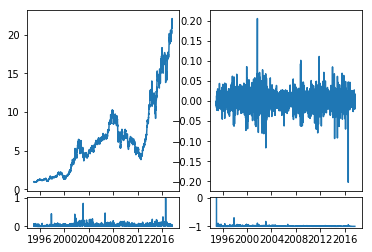

In [8]:
sdp.stock_plot(data_n)

# Transform Data

In [9]:
# training data
prediction_time = 30 #day
testdatasize = 450
unroll_length = 90
testdatacut = testdatasize + unroll_length  + 1

x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()



In [10]:
x_train

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -1.48149000e-01,   0.00000000e+00,   1.55000000e+04, ...,
         -3.17458637e-03,  -3.17458637e-03,  -1.58729862e-02],
       [  0.00000000e+00,   1.48149000e-01,  -4.65000000e+04, ...,
          3.21543101e-03,   6.43086203e-03,   0.00000000e+00],
       ..., 
       [ -2.12999700e+00,  -1.12999700e+00,   8.11000000e+04, ...,
         -2.22251008e-03,   1.69899195e-03,  -2.88891814e-02],
       [ -1.17000600e+00,   9.59991000e-01,   3.13500000e+05, ...,
         -4.70597023e-03,   1.34491213e-03,  -1.60008099e-02],
       [  1.24000500e+00,   2.41001100e+00,  -2.43400000e+05, ...,
          8.19625464e-04,   2.44534489e-02,  -8.19759661e-04]])

In [11]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5141, 16)
y_train (5141,)
x_test (511, 16)
y_test (511,)


# Convert to time series

In [12]:
x_train = sdp.unroll(x_train,unroll_length)
x_test  = sdp.unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5051, 90, 16)
y_train (5051,)
x_test (421, 90, 16)
y_test (421,)


# Model Building

In [13]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

Using TensorFlow backend.


In [21]:
x_train.shape

(5051, 90, 16)

In [45]:
model = lstm.build_model([1, 50, 100, 1])

/Users/ahendel1/Documents/Academics/4cast/lstm.py:66: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  return_sequences=True))


Compilation Time :  0.012423276901245117


/Users/ahendel1/Documents/Academics/4cast/lstm.py:75: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  output_dim=layers[3]))


In [46]:
model.get_input_shape_at(node_index=0)

(None, 50, 1)

In [62]:
from pandas import concat
from pandas import DataFrame
# create sequence
length = 10
sequence = [i/float(length) for i in range(length)]
# create X/y pairs
df = DataFrame(sequence)
df = concat([df, df.shift(1)], axis=1)
df.dropna(inplace=True)
print(df)
import pandas as pd
from pandas import concat
length = 10
sequence = [i/float(length) for i in range(length)]
# create X/y pairs
df = pd.DataFrame(sequence)
df = concat([df, df.shift(1)], axis=1)
df.dropna(inplace=True)
# convert to LSTM friendly format
values = df.values
X, y = values[:, 0], values[:, 1]

     0    0
1  0.1  0.0
2  0.2  0.1
3  0.3  0.2
4  0.4  0.3
5  0.5  0.4
6  0.6  0.5
7  0.7  0.6
8  0.8  0.7
9  0.9  0.8


In [66]:
y

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8])

In [61]:
X = X.reshape(len(X), 1, 1)
print(X.shape, y.shape)

n_batch = len(X)
n_epoch = 1000
n_neurons = 10
# design network
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))

     0    0
1  0.1  0.0
2  0.2  0.1
3  0.3  0.2
4  0.4  0.3
5  0.5  0.4
6  0.6  0.5
7  0.7  0.6
8  0.8  0.7
9  0.9  0.8
(9, 1, 1) (9,)


In [60]:
y

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8])

In [48]:
model.get_input_shape_at(0)

(9, 1, 1)

In [49]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_shape=(None, x_train.shape[-1]),
    units = 10,
    return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
    units = 100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.012625932693481445


In [50]:
model.get_input_shape_at(node_index=0)

(None, None, 16)

In [28]:
##### Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=3,
    validation_split=0.3)

KeyboardInterrupt: 

In [19]:
model.save('lstm_astc.h5')

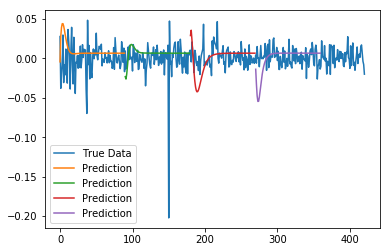

In [23]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, x_test, 90, 90)
lstm.plot_results_multiple(predictions, y_test, 90)

In [14]:
predictions = lstm.predict_point_by_point(model, x_test)
lstm.plot_results_multiple(predictions, y_test, 50)

NameError: name 'lstm' is not defined